In [1]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import scipy as sci
from sklearn.cluster import KMeans


# Utils

In [2]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """  
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    Degrees=np.diag(np.sum(adjacency,1))
    #print(  (np.sum(adjacency,1) == 0).any()   )
    if normalize==False:
        L=Degrees-adjacency
    if normalize==True:
        D_norm=np.diag(np.sum(adjacency,1)**(-1/2))
        L=D_norm@(Degrees-adjacency)@D_norm
    return L

def spectral_decomposition(laplacian: np.ndarray):
    lamb, U=sci.linalg.eigh(laplacian)
    sorted_idx = np.argsort(lamb)
    lamb = lamb[sorted_idx]
    U=U[:,sorted_idx]
    return lamb,U


def GFT(signal, U):
    # Your code here
    print(len(signal))
    return U.T @ signal

def iGFT(fourier_coefficients, U):
    # Your code here
    return U @ fourier_coefficients
def ideal_graph_filter(x, spectral_response, U):
    """Return a filtered signal."""
    # Your code here
    # spectral_response is in the fourier domain
    # x is in the graph domain
    # need to converge x to the fourier domain 
    # finally convert all back to the graph domain
    return iGFT(GFT(x,U) * spectral_response, U)

# Prepare data

In [3]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

In [4]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

# keep only summury information of each county
df_migrations = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration")]

# create the combined fips county number 
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# drop useless information 
df_migrations = df_migrations.drop(columns=["y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str"])

# seperate each possible migration into three dataframe 
df_migration_total = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US and Foreign")]
df_migrations['y1_countyname'] = df_migrations['y1_countyname'].apply(lambda x : x if x.find("County Total Migration-US and Foreign") == -1 else "County Total Migration Both")
df_migration_us = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US")]
df_migration_for = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-Foreign")]

# drop the name of the column 
df_migration_total = df_migration_total.drop(columns=["y1_countyname"])
df_migration_us = df_migration_us.drop(columns=["y1_countyname"])
df_migration_for = df_migration_for.drop(columns=["y1_countyname"])

# remove nodes where data is undefined undefined data by zero
df_migration_total = df_migration_total[df_migration_total['n1'] != -1]
df_migration_us = df_migration_us[df_migration_us['n1'] != -1]
df_migration_for = df_migration_for[df_migration_for['n1'] != -1]

# convert combined fips to int64
df_migration_total['combined_fips'] = df_migration_total['combined_fips'].astype('int64')
df_migration_us['combined_fips'] = df_migration_us['combined_fips'].astype('int64')
df_migration_for['combined_fips'] = df_migration_for['combined_fips'].astype('int64')

In [5]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

In [6]:
# merge the two dataset and drop useless column, add a new column winner 
df_merged_total = pd.merge(df_migration_total, df_presidential_result, on="combined_fips", how='inner')
df_merged_us = pd.merge(df_migration_us, df_presidential_result, on="combined_fips", how='inner')
df_merged_for = pd.merge(df_migration_for, df_presidential_result, on="combined_fips", how='inner')
df_merged_total['difference'] = df_merged_total['per_dem'] - df_merged_total['per_gop']
df_merged_us['difference'] = df_merged_us['per_dem'] - df_merged_total['per_gop']
df_merged_for['difference'] = df_merged_for['per_dem'] - df_merged_total['per_gop']
df_merged_total['winner'] = df_merged_total['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_us['winner'] = df_merged_us['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_for['winner'] = df_merged_for['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_total = df_merged_total.drop(columns=['difference'])
df_merged_us = df_merged_us.drop(columns=['difference'])
df_merged_for = df_merged_for.drop(columns=['difference'])

# Compute Adjacency matrix

0.5284353963018223


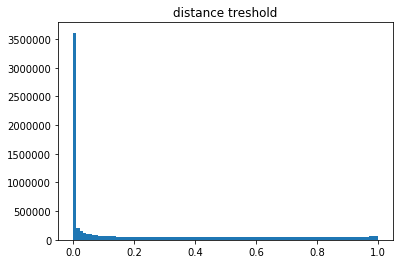

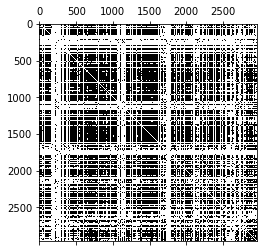

In [7]:
X_total = df_merged_total.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_total = df_merged_total.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_total['agi'] = (X_total['agi'] - X_total['agi'].mean()) / X_total['agi'].std()
X_total['prop_ret/exempt'] = X_total['n1'] / X_total['n2']
X_total = X_total.drop(columns=['n1', 'n2'])
adjacency_RGB_total = epsilon_similarity_graph(X_total, sigma=0.5284353963018223*0.1, epsilon=0.2)
plt.spy(adjacency_RGB_total)
plt.show()

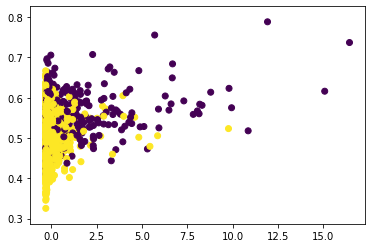

In [8]:
plt.scatter(X_total["agi"], X_total["prop_ret/exempt"], c=df_merged_total["winner"])
plt.show()

# signal => gft => lp => igft => adjacency and neighbour => threshold

### Division by zero in normalized lapacien computation

- some nodes do not have any connection in the graph => create new adjacency matrix A by deleting these nodes

# Randomly choose some points for prediction use

In [32]:
def pred_iteration(A,iters, x, n, filtered_x_lp):
    accurary =[]
    for i in iters:
        test_idx = np.random.choice(np.arange(len(x)),n,replace = False)
        # masking some winner
        x[test_idx]=0
        #prepare ground truth
        truth = (df_merged_total["winner"][test_idx]).values

        pred = []
        for i in test_idx:
            l = np.where(A[i] !=0)[0]  # searching neigbhours
            tmp = 0
            for j in l:
                
                tmp += filtered_x_lp[j]
            pred.append(tmp/len(l))   # compute mean
        # thresholding
        pred_thres = np.array(pred)
        pred_thres [pred_thres >0 ] = 1
        pred_thres [pred_thres <0 ] = -1

        # ground truth
        truth = (df_merged_total["winner"][test_idx]).values

        right_pred = []
        for i in range(len(pred_thres)):
            if(pred_thres[i] == truth[i]):
                right_pred.append(i)
                
        accurary.append( len(right_pred)/len(test_idx))
        
    mean = np.mean(accurary)
    var = np.std(accurary)
    print("The mean is ",mean)
    print("The variance is ",var)
    return mean,var

In [12]:
# prepare A and x(signal)
A = adjacency_RGB_total.copy()
rows_to_be_deleted = np.where(np.sum(adjacency_RGB_total,1) == 0)
A = np.delete(A, rows_to_be_deleted,0)
A = np.delete(A, rows_to_be_deleted,1)
x = df_merged_total["winner"]
x = np.delete(np.array(x), rows_to_be_deleted,0) 
# compute lamb and U
laplacian = compute_laplacian(A, normalize=True)
lamb, U = spectral_decomposition(laplacian)

In [13]:
# prepare filter
n_nodes = A.shape[0]
ideal_lp = np.ones((n_nodes,)) 
ideal_lp[lamb >= 0.1] = 0   # to tune
# apply filter
x_lp = ideal_graph_filter(x,ideal_lp,U)

2939


In [14]:
iters = np.arange(10)
n = int(len(x)*0.2)

In [15]:
accuracy_mean, accuracy_var = pred_iteration(A,iters, x, n, x_lp)

The mean is  0.8201022146507666
The variance is  0.015222015607283607


(0.8201022146507666, 0.015222015607283607)

# Questions:
- algo: why low pass; [0,1,-1,1,0] => iGFT(GFT*lp) =>  [_,?,?,?,_]
- plot with lamb ?
- good graph ?  => `agi` and `exemplt` can predict the winner at 82%
- satisfactory result ?

# FOR

0.6675252605174871


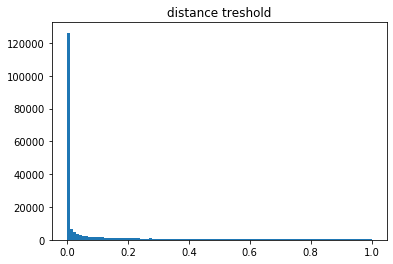

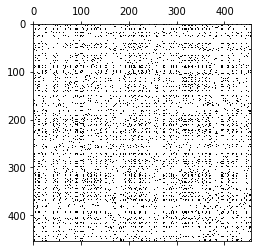

In [16]:
X_for = df_merged_for.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_for = df_merged_for.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_for['agi'] = (X_for['agi'] - X_for['agi'].mean()) / X_for['agi'].std()
X_for['prop_ret/exempt'] = X_for['n1'] / X_for['n2']
X_for = X_for.drop(columns=['n1', 'n2'])
adjacency_RGB_for = epsilon_similarity_graph(X_for, sigma=0.6675252605174871*0.1, epsilon=0.5)
plt.spy(adjacency_RGB_for)
plt.show()

In [17]:
# prepare A and x(signal)
A_for = adjacency_RGB_for.copy()
rows_to_be_deleted_for = np.where(np.sum(adjacency_RGB_for,1) == 0)
A_for = np.delete(A_for, rows_to_be_deleted_for,0)
A_for = np.delete(A_for, rows_to_be_deleted_for,1)
x_for = df_merged_for["winner"]
x_for = np.delete(np.array(x_for), rows_to_be_deleted_for,0) 
# compute lamb and U
laplacian_for = compute_laplacian(A_for, normalize=True)
lamb_for, U_for = spectral_decomposition(laplacian_for)

In [18]:
# prepare filter
ideal_lp_for = np.ones((A_for.shape[0],)) 
ideal_lp_for[lamb_for >= 0.1] = 0   # to tune
# apply filter
x_lp_for = ideal_graph_filter(x_for,ideal_lp_for,U_for)

437


In [29]:
iters_for = np.arange(10)
n_for = int(len(x_for)*0.2)

In [35]:
accuracy_mean_for, accuracy_var_for = pred_iteration(A_for,iters_for, x_for, n_for, x_lp_for)

The mean is  0.7195402298850574
The variance is  0.03784385662794099


(0.7195402298850574, 0.03784385662794099)

# US

0.5310405705207334


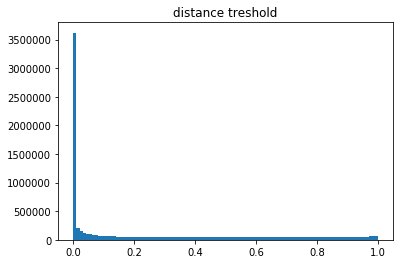

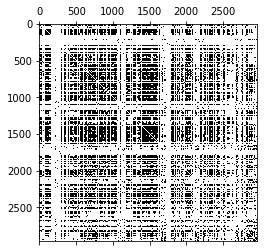

In [36]:
X_us = df_merged_us.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_us = df_merged_us.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_us['agi'] = (X_us['agi'] - X_us['agi'].mean()) / X_us['agi'].std()
X_us['prop_ret/exempt'] = X_us['n1'] / X_us['n2']
X_us = X_us.drop(columns=['n1', 'n2'])
adjacency_RGB_us = epsilon_similarity_graph(X_us, sigma=0.5310405705207334*0.1, epsilon=0.5)
plt.spy(adjacency_RGB_us)
plt.show()

In [37]:
# prepare A and x(signal)
A_us = adjacency_RGB_us.copy()
rows_to_be_deleted_us = np.where(np.sum(adjacency_RGB_us,1) == 0)
A_us = np.delete(A_us, rows_to_be_deleted_us,0)
A_us = np.delete(A_us, rows_to_be_deleted_us,1)
x_us = df_merged_us["winner"]
x_us = np.delete(np.array(x_us), rows_to_be_deleted_us,0) 
# compute lamb and U
laplacian_us = compute_laplacian(A_us, normalize=True)
lamb_us, U_us = spectral_decomposition(laplacian_us)

In [38]:
# prepare filter
ideal_lp_us = np.ones((A_us.shape[0],)) 
ideal_lp_us[lamb_us >= 0.1] = 0   # to tune
# apply filter
x_lp_us = ideal_graph_filter(x_us,ideal_lp_us,U_us)

2921


In [39]:
iters_us = np.arange(10)
n_us = int(len(x_for)*0.2)

In [41]:
accuracy_mean_us, accuracy_var_us = pred_iteration(A_us,iters_us, x_us, n_us, x_lp_us)

The mean is  0.8195402298850574
The variance is  0.03293459490090667


(0.8195402298850574, 0.03293459490090667)